In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import opendatasets as od
from datetime import datetime, date, time
from matplotlib.image import imread
%matplotlib inline
sns.set()

In [2]:
ford = pd.read_csv('ford.csv')
ford

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6
17964,KA,2018,8299,Manual,5007,Petrol,145,57.7,1.2


In [3]:
ford.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17966 entries, 0 to 17965
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17966 non-null  object 
 1   year          17966 non-null  int64  
 2   price         17966 non-null  int64  
 3   transmission  17966 non-null  object 
 4   mileage       17966 non-null  int64  
 5   fuelType      17966 non-null  object 
 6   tax           17966 non-null  int64  
 7   mpg           17966 non-null  float64
 8   engineSize    17966 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [4]:
ford.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

# **Lets do some Exploration and Data Analysis**

In [5]:
model = ford.model.value_counts().to_frame()
model.head()

,model
Fiesta,6557
Focus,4588
Kuga,2225
EcoSport,1143
C-MAX,543


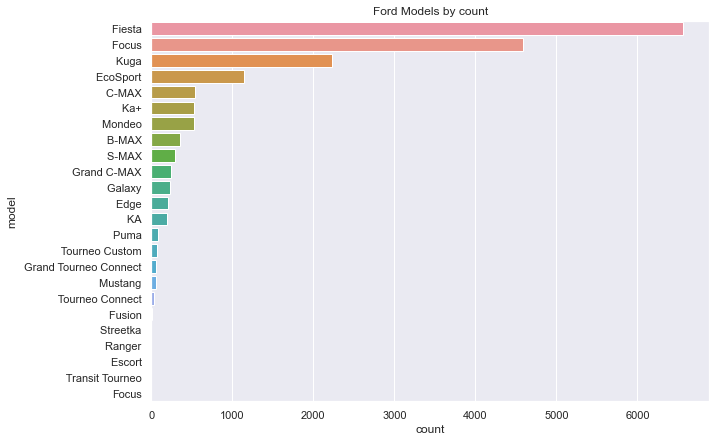

In [6]:
# check the models by count
fig,ax = plt.subplots(figsize = (10,7))
sns.barplot(data = model, x = model.model, y = model.index);
ax.set(title = 'Ford Models by count',xlabel = 'count',ylabel = 'model');

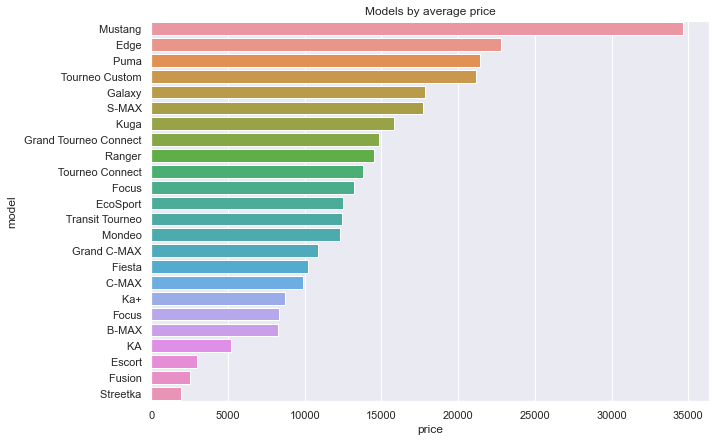

In [7]:
# model price by year
fig,ax = plt.subplots(figsize = (10,7))
mpy = ford.loc[:, ['model','price']]
sns.barplot (data = mpy.groupby('model').mean().sort_values('price', ascending = False),\
            y = mpy.groupby('model').mean().sort_values('price', ascending = False).index, \
            x =  mpy.groupby('model').mean().sort_values('price', ascending = False).price, ax= ax);
ax.set(title = 'Models by average price');

In [8]:
ford.corr()[:4]

,year,price,mileage,tax,mpg,engineSize
year,1.000000,0.636009,-0.707818,0.298506,-0.022967,-0.137311
price,0.636009,1.000000,-0.530659,0.406857,-0.346419,0.411178
mileage,-0.707818,-0.530659,1.000000,-0.260451,0.120075,0.215035
tax,0.298506,0.406857,-0.260451,1.000000,-0.502980,0.184363


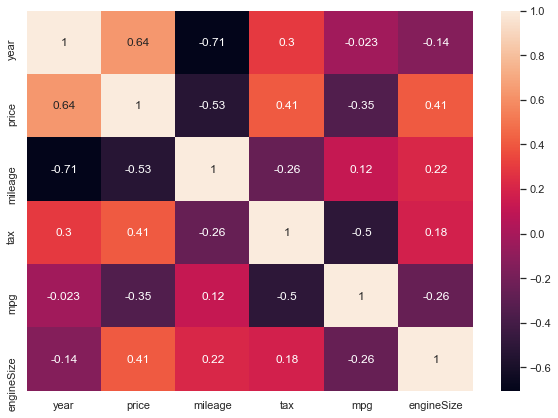

In [9]:
fig,ax = plt.subplots(figsize = (10,7))
sns.heatmap(ford.corr(),annot= True,ax=ax);

## **Feature correlations**
# 1. higher price if engine size is larger
# 2. higher price results in high tax
# 3. higher price results i higher model year
# 4. higher mileage result in lower price

In [10]:
# split the data
X= ford.drop('price', axis = 1)
y =ford['price']

In [11]:
len(X) , len(y)

(17966, 17966)

# **Preprocessing => converting non numeric features to numeric**

In [12]:
# changing the car categories into to numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# now defime our categorical features
categorical_features  = ['model','transmission','fuelType']
one_hot = OneHotEncoder()
transformer = ColumnTransformer ([("one_hot",
                                   one_hot,
                                   categorical_features)],
                                 remainder= 'passthrough',sparse_threshold=0)   # will take in a turple
                                 
                                 
new_X = transformer.fit_transform(ford)
new_X.shape   # this is X that has undergone cleaning

(17966, 38)

In [13]:
# import model
from sklearn.ensemble import RandomForestRegressor


# split into train and test
from sklearn.model_selection import train_test_split

# split the data
X= ford.drop('price', axis = 1)
y =ford['price']

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2 )

#****************************************************************************************************
# fit the model
model= RandomForestRegressor()  #clf can also be called model
model.fit(X_train, y_train)


# predict the model
y_preds = model.predict(X_test)
y_preds

array([ 6995.  ,  8999.  ,  7998.  , ..., 24988.09, 10500.  , 19713.93])

In [14]:
# Evaluation of the model
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error

# inbuilt score 
print(f'Training Score:{model.score(X_train, y_train)}') # inbuilt accuracy score
print(f'Test Score: {model.score(X_test, y_test)}')     # inbuilt accuracy score

print()
# cross validation score
from sklearn.model_selection import cross_val_score
print(f"Classifier Cross Validation_Score: {cross_val_score(model,new_X,y,cv= 5)}") # cross validation
print(f"Classifier Cross Validation_Score_Mean: {np.mean(cross_val_score(model,new_X,y,cv= 5))}") # cross validation

print()
# Mean Absolute error
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
print(f'mean_absolute_error : {mean_absolute_error}')

# Mean Squared Values
from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(y_test, y_pred)
print(f'mean_squared_error : {mean_squared_error}')

Training Score:0.9999654172568951
Test Score: 0.9999838454638043

Classifier Cross Validation_Score: [0.99998601 0.99999676 0.99999432 0.99863456 0.99987798]
Classifier Cross Validation_Score_Mean: 0.9996230915504946

mean_absolute_error : 1.8688230383973494
mean_squared_error : 362.0563000834745


## **Lets Fine tune the model's parameter  with RandomSearchCV**

In [15]:
# Randomized Search CV Tunining

# import hyperparameter tuning with randomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators":[10,50,100],
        "max_depth" : [None, 5, 10, 20, 30 ],
        "max_features" :['auto',"sqrt"],
        "min_samples_split" : [2,4,6],
        "min_samples_leaf" : [2,4,6],
       "bootstrap" : [True, False]
       }

# create seed
np.random.seed(42)


# train and split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(new_X,y, test_size = 0.2)

# instantiate RandomForest Classifier
clf = RandomForestRegressor(n_jobs = -1)  # n_jobs is the number of cores you want to use for computing

# setup RandomizedSearchCV
random =RandomizedSearchCV (estimator = clf,
                          param_distributions = grid,
                          n_iter = 5,
                          cv=5,
                          verbose = 2)

# fint the RandomizedSearchCV version of fit
random.fit(X_train, y_train)
# print(‘Best hyper parameter:’, random.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   2.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 50, 100]},
                   verbose=2)

In [16]:
random.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [17]:
# make predictions  with the best hyperparamaters
rscv_preds = random.predict(X_test)
rscv_preds.shape, y_test.shape
# Evaluate predictiions
#rs_metric = evaluate_preds(y_test, rs_y_preds)

((3594,), (3594,))

In [18]:
random.score(X_test, y_test)

0.9999837718903106